# Publications Hypergraph Demo Notebook

This notebook is used to replcate the use case experiment in the paper **PAPER LINK HERE** that demonstrates the use of the hypergraph interchange formation (HIF).

The following hypergraph libraries have the HIF loading and saving functions allowing for the analysis of the same hypergraph over each library:
* HyperNetX (HNX)
* HyperGraphX (HGX)
* SimpleHypergraphs
* TopoNetX
* Hypergraph Analysis Toolbox (HAT)
* compleX Group Interactions (XGI)

## Publications Data as a Hypergraph

This dataset consists of open source publications with the keyword "Hypergraph" and was collected from ArXiv, Biorxiv, DBLP and Osti. The Hypergraph has hyperedges as publications and nodes as authors. The hyperedges have attributes including funding agencies, abstract, publication date, tags, and source, while the nodes have the attributes of institutions.

In [4]:
# import standard packages for analysis and plotting
import matplotlib.pyplot as plt
import numpy as np
import json

In [5]:
file_path = 'data/publications.hif.json'
with open(file_path, 'r') as f:
        HIF_publications = json.load(f)

# HyperNetX

Here we demo loading in the hypergraph using HNX and demoing the unique homology capabilities of the library.

In [14]:
import hypernetx as hnx

In [15]:
H_publications = hnx.from_hif(HIF_publications)

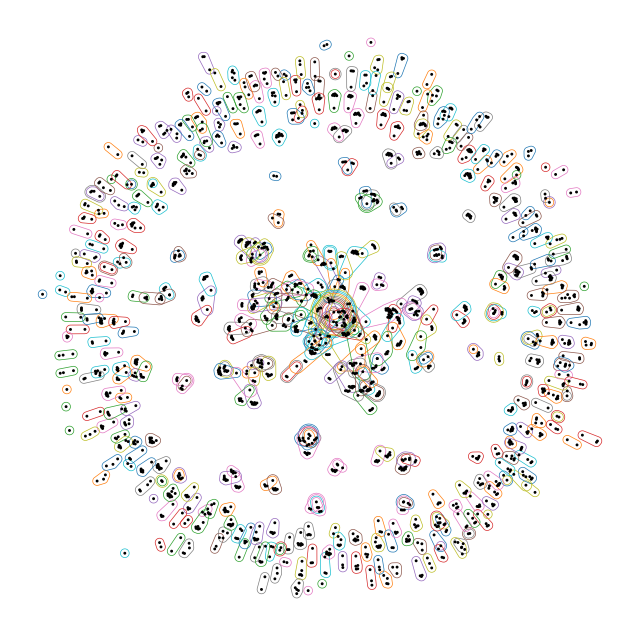

In [16]:
hnx.draw(H_publications, with_edge_labels = False, with_node_labels = False, node_radius = 0.2, edges_kwargs = {'lw': 0.5})
plt.show()

In [46]:
# Getting the main connected component of hypergraph
import numpy as np
Hs = list(H_publications.s_component_subgraphs(s = 1, return_singletons = False))
I = np.argsort([len(H_CC.incidences.dataframe) for H_CC in Hs])
Hs = [Hs[i] for i in I]
H = Hs[-1]

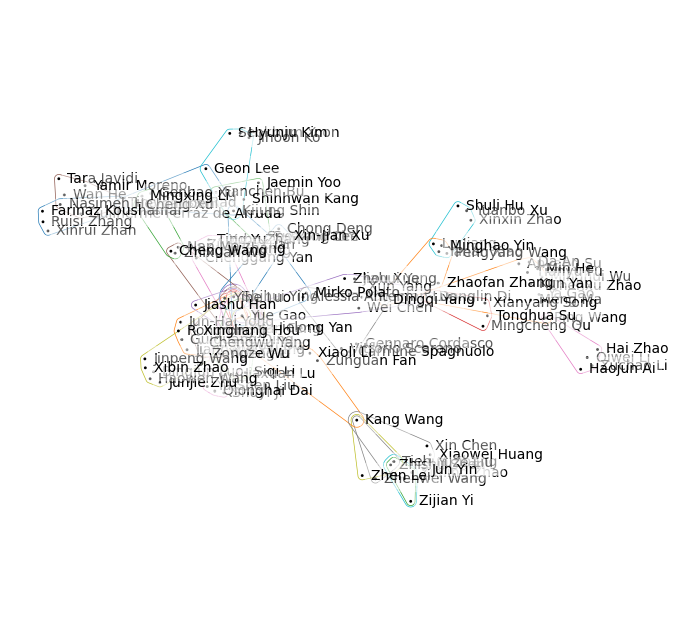

In [55]:
pos = hnx.draw(H, with_edge_labels = False, with_node_labels = True, node_radius = 0.2, edges_kwargs = {'lw': 0.5}, return_pos = True)
plt.show()

## One-Dimensional Homology of a Hypergraph Using HNX

/var/folders/61/p7yt794x1039z84jfr_kddd40000gn/T/ipykernel_78823/721124748.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


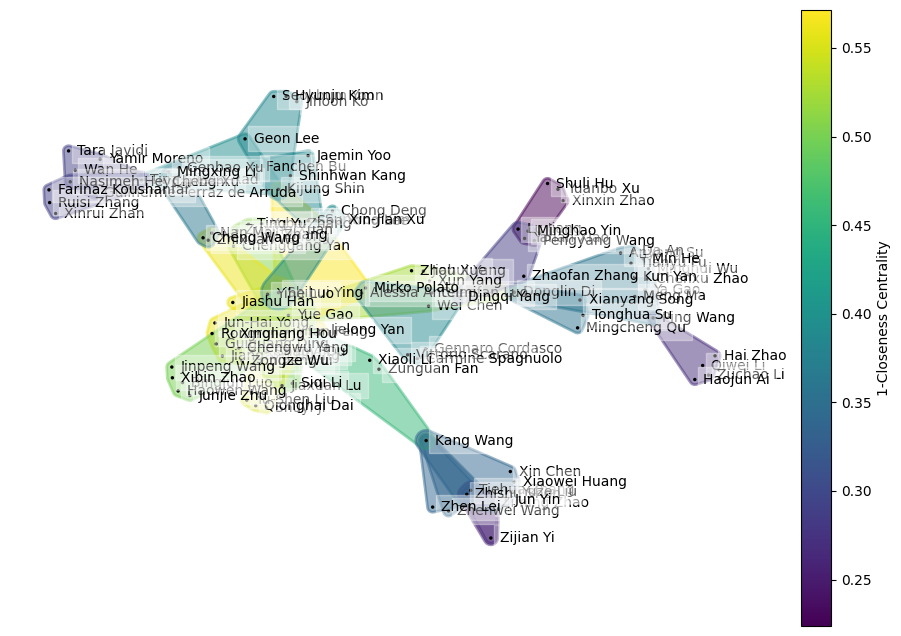

In [58]:
import hypernetx as hnx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

# Assuming your hypergraph 'H' is already defined
s = 1
edge_centrality = hnx.s_closeness_centrality(H, s=s)

# Get the centrality values and the edges
edges = list(H.edges)
centrality_values = np.array([edge_centrality[e] for e in edges])

# Normalize the centrality values to the range [0, 1]
if centrality_values.size > 0:
    normalized_centrality = (centrality_values - np.min(centrality_values)) / (np.max(centrality_values) - np.min(centrality_values))
else:
    normalized_centrality = np.array([]) # Handle the case of no edges

# Choose a colormap
cmap = cm.get_cmap('viridis')

# Map the normalized centrality values to colors
edge_colors = cmap(normalized_centrality)

# Create a dictionary to pass to edges_kwargs for coloring
edge_style = {}
for i, edge in enumerate(edges):
    if i < len(edge_colors):
        edge_style[edge] = edge_colors[i]

# Create the hypergraph plot
fig, ax = plt.subplots(figsize = (12,8))
hnx.draw(H, pos = pos, with_edge_labels=False, with_node_labels=True, node_radius=0.2, 
         edges_kwargs={'color': list(edge_style.values()), 'lw': 2, 'alpha': 0.5}, ax=ax)

# Add the colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=np.min(centrality_values), vmax=np.max(centrality_values)))
sm.set_array([])  # For older versions of matplotlib
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(f'{s}-Closeness Centrality')

plt.show()

In [59]:
s = 1
print(f'The {s}-closeness centrality of the edges in hypergraph H is:')
print('-'*100)

d = hnx.s_closeness_centrality(H,s=s)
for e in H.edges:
    print(f'{e}: {d[e]}')


The 1-closeness centrality of the edges in hypergraph H is:
----------------------------------------------------------------------------------------------------
A Survey on Hypergraph Mining: Patterns, Tools, and Generators: 0.3950617283950617
Hyper-YOLO: When Visual Object Detection Meets Hypergraph Computation: 0.5614035087719298
HyperSMOTE: A Hypergraph-based Oversampling Approach for Imbalanced Node Classifications: 0.2601626016260163
LightHGNN: Distilling Hypergraph Neural Networks into MLPs for $100\times$ Faster Inference: 0.5614035087719298
Hyper-3DG: Text-to-3D Gaussian Generation via Hypergraph: 0.5245901639344263
Assigning Entities to Teams as a Hypergraph Discovery Problem: 0.2882882882882883
Hypergraph based Understanding for Document Semantic Entity Recognition: 0.26666666666666666
Towards Multi-agent Policy-based Directed Hypergraph Learning for Traffic Signal Control: 0.3368421052631579
Hypergraph-based Multi-View Action Recognition using Event Cameras: 0.5
Multimodal F

# Add your library here with an example of a unique functionality it provides...